In [1]:
import numpy as np
import  pandas as pd
df=pd.read_csv('Online Retail Dataset.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
df=df.loc[(df['Quantity']>0)]

In [3]:
product_distance=pd.read_csv('poduct_distance_horizantal_new_2.csv')

In [4]:
def preprocessing(n):
    orders=df['InvoiceNo'].unique().tolist()
    scales=orders[:n]
    orderdf=df.loc[df['InvoiceNo'].isin(scales)]
    allusedproduct=product_distance['Description'].tolist()
    orderdist=orderdf.loc[orderdf['Description'].isin(allusedproduct)]
    orderdist=orderdist.merge(product_distance[['Description','a_k','r_k','distance','isle']],how='left',on=['Description'])
    orderdist
    orderinfo1=orderdist.groupby(['InvoiceNo','Description'])['Quantity'].sum().reset_index()
    orderinfo2=orderdist.groupby(['InvoiceNo','Description'])['isle'].max().reset_index()
    orderinfo=orderinfo1.merge(orderinfo2[['InvoiceNo','Description','isle']],how='left',on=['InvoiceNo','Description'])
    orderinfo=orderinfo.merge(product_distance[['Description','a_k','r_k']],how='left',on=['Description'])
    return orderinfo

In [5]:
from gurobipy import GRB , Model , quicksum #*
import random
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
from gurobipy import GRB , Model , quicksum #*
import math
import time

In [6]:
def Output (m):
    status_code = {1: 'LOADED', 2: 'OPTIMAL', 3:'INFEASIBLE', 4: 'INF_OR_UNBD', 5: 'UNBOUNDED'}
    status = m.status
    print ('The optimization status is ' + status_code[status])
    if status == 2:
        print ('Optimal solution :')
        for v in m.getVars () :
            print (str (v.varName ) + " = " + str( v.x))
        print ('Optimal objective value : ' + str( m.objVal ) + "\n")

In [7]:
#last(fifth) version
def ModelImplement_5(I,B,K,Q,m_i,a_ik,n_r,alpha,d_ij):
    model = Model ('Batching Model no z w')
    model.setParam ('OutputFlag', True )
    model.setParam('TimeLimit', 120)
    x = model.addVars(I ,B , vtype = GRB.BINARY , name =[ 'x_' + str (i +1) +'_'+ str(b +1) for i in range(I) for b in range(B)])
    y = model.addVars(B , vtype = GRB.BINARY , name =[ 'y_' + str(b +1) for b in range(B)])
    z = model.addVars(K ,B , vtype = GRB.BINARY , name =[ 'z_' + str (k +1) +'_'+ str(b +1) for k in range(K) for b in range(B)])
    # Minimize
    obj=0
    for i in range(I):
        for j in range(I):
            obj=obj+d_ij[i][j]*quicksum(x[i,b]*x[j,b] for b in range(B))
    model.setObjective (obj , GRB.MINIMIZE )
    # Assignment constraints
    model.addConstrs(sum(x[i,b] for b in range(B)) == 1 for i in range(I))
    #model.addConstrs(quicksum(a_ik[i][k]*x[i,b]for i in range(I)) <= z[k,b] for k in range(K) for b in range(B) )
    model.addConstrs((quicksum(m_i[i]* x[i,b] for i in range(I))<=Q* y[b]) for b in range(B))
    model.addConstr(sum(y[b] for b in range(B)) <= n_r)
    
    #model.addConstrs(d_ij[i][j]*x[i,b]*x[j,b]<=w for i in range(I) for j in range(I) for b in range(B))
    
    # Optimize the model
    model.optimize()
    if model.status==2:
        varInfo = [[v.varName, v.X] for v in model.getVars() if v.X>0]
        zval=model.getObjective()
        z=zval.getValue()
    else:
        varInfo=0
        zval=0
        z=0
    #Output(model)
    return z,varInfo,model.status

In [22]:
n_list=[5,6,7,10,12,15,15,17,20,25]
B_list=[5,10,10,15,20,25,20,20,25,40]
T_list=[100,100,100,100,200,400,400,400,400,600]
batch_list=dict(zip(n_list, B_list))
capacity_list=dict(zip(n_list, T_list))
def parameters(n):
    B=batch_list[n]
    n_r=B
    T=capacity_list[n]
    K=40
    alpha=math.ceil((130+29)/K)
    orderinfo=preprocessing(n)
    I=len(orderinfo)
    m_i=orderinfo['Quantity'].tolist()
    islelist=orderinfo['isle'].tolist()
    a_ik=[]
    for i in range(I):
        x=[]
        for k in range(K):
            if islelist[i]-1==k:
                x.append(1)
            else:
                x.append(0)
        a_ik.append(x)
    a_kval=orderinfo['a_k'].tolist()
    r_kval=orderinfo['r_k'].tolist()
    isl=orderinfo['isle'].tolist()
    d_ij2=[]
    topisle=[i for i in range(1,22)]
    bottomisle=[l for l in range(22,43)]
    allisle=[i for i in range(1,43)]
    points=[]
    points.append(10)
    for i in range(14,129,6):
        points.append(i)
    edges=dict(zip(allisle, points*2))
    for i in range(I):
        dist=[]
        for j in range(I):
            isle_i=isl[i]
            isle_j=isl[j]
            #up to down
            if isle_i==isle_j or edges[isle_i]==edges[isle_j]:
                val_x=abs(a_kval[i]-a_kval[j])
                val_y=abs(r_kval[i]-r_kval[j])
                val=val_x+val_y
            else:
                if isle_i<=21 and isle_j<=21:
                    val_x=abs(a_kval[i]-a_kval[j])
                    val_y_1=abs(r_kval[i]-14.5)+abs(14.5-r_kval[i])
                    val_y_2=abs(r_kval[i]-2)+abs(2-r_kval[i])
                    val_y=min(val_y_1,val_y_2)
                elif isle_i<=21 and isle_j>21:
                    val_x=abs(a_kval[i]-a_kval[j])
                    val_y=abs(r_kval[i]-14.5)+abs(14.5-r_kval[i])
                elif isle_i>21 and isle_j>21:
                    val_x=abs(a_kval[i]-a_kval[j])
                    val_y_1=abs(r_kval[i]-14.5)+abs(14.5-r_kval[i])
                    val_y_2=abs(r_kval[i]-27)+abs(27-r_kval[i])
                    val_y=min(val_y_1,val_y_2)
                val=val_x+val_y
            dist.append(round(val,2))
        d_ij2.append(dist)
    return n, B, n_r, T,K,alpha, orderinfo,I,m_i,a_ik,d_ij2
n, B, n_r, T,K,alpha, orderinfo,I,m_i,a_ik,d_ij=parameters(5)
n

5

In [24]:
start_time5 = time.perf_counter()
z5, varInfo5, status5 = ModelImplement_5(I, B, K, T, m_i, a_ik, n_r,alpha,d_ij)
end_time5 = time.perf_counter()
print(end_time5-start_time5)

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 330 columns and 260 nonzeros
Model fingerprint: 0x1cc4dbe6
Model has 1500 quadratic objective terms
Variable types: 0 continuous, 330 integer (330 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3736.6000000
Presolve removed 1 rows and 205 columns
Presolve time: 0.01s
Presolved: 1530 rows, 1625 columns, 4750 nonzeros
Variable types: 0 continuous, 1625 integer (1625 binary)

Root relaxation: objective 0.000000e+00, 69 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds   

In [10]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [25]:
def print_graph(varInfo):
    import re
    import matplotlib.lines as lines
    # extract the values of the x variable from varInfo
    x_values = [var[0] for var in varInfo if var[0].startswith('x_')]
    newnames=[]
    for i in x_values:
        split_string = re.findall(r'\d+', i)
        newnames.append(split_string)
    assign=[]
    for j in range(0,len(newnames)):
        assign.append(newnames[j][1])
    orderinfo['batch']=assign
    # Define the layout of the warehouse
    # Here we will assume a simple 2D layout with fixed dimensions
    warehouse_width = 130
    warehouse_height = 29
    cmap = get_cmap(B+1)
    # Create a figure and axis for the warehouse layout
    fig, ax = plt.subplots(figsize=(warehouse_width, warehouse_height))
    ax.set_xlim(0, warehouse_width)
    ax.set_ylim(0, warehouse_height)
    x_val=orderinfo['a_k'].tolist()
    y_val=orderinfo['r_k'].tolist()
    #add robots
    avg=orderinfo.groupby('batch')['r_k'].mean().reset_index()
    top=avg.loc[avg['r_k']<=16]
    bottom=avg.loc[avg['r_k']>16]
    toplist=top['batch'].tolist()
    bottomlist=bottom['batch'].tolist()
    topisle=[i for i in range(1,22)]
    bottomisle=[l for l in range(22,43)]
    allisle=[i for i in range(1,43)]
    points=[]
    points.append(10)
    for i in range(14,129,6):
        points.append(i)
    edges=dict(zip(allisle, points*2))
    for i in range(0,len(toplist)):
        ax.add_patch(plt.Circle((i+2, 2), 0.5, color=cmap(int(toplist[i])))) 
        res_1 = dict(zip(topisle, bottomisle))
        res_2 = dict(zip(bottomisle, topisle))
        try_1=orderinfo.loc[orderinfo['batch']==toplist[i]]
        try_isle=try_1['isle'].unique().tolist()
        small_list = [int(t) for t in try_isle if int(t) <22]
        large_list = [res_2[int(t)] for t in try_isle if int(t) >= 22]
        small=['s']*len(small_list)
        large=['l']*len(large_list)
        all_list=small_list+large_list
        all_name=small+large
        dict_all = dict(zip(all_list, all_name))
        myKeys = list(dict_all.keys())
        myKeys.sort()
        sorted_dict = {i: dict_all[i] for i in myKeys}
        #small_list.sort()
        #large_list.sort()
        initial_point=[i+2,2]
        
        for k in range(0,len(sorted_dict)):
            ind=list(sorted_dict.keys())[k]
            if k!=len(sorted_dict)-1:
                lar=list(sorted_dict.values())[k+1]
            else:
                lar=list(sorted_dict.values())[k]
            if k%2==0:
                if k==0 and ind%2!=0:
                    indxl=edges[ind]-1
                else:
                    indxl=edges[ind]+1
                new_point=[indxl,2]
                ax.hlines(y = initial_point[1], xmin = initial_point[0], xmax = new_point[0],color = cmap(int(toplist[i])))
                if list(sorted_dict.values())[k]=='l' or lar=='l':
                    ax.vlines(x = new_point[0], ymin = initial_point[1], ymax = 27, colors = cmap(int(toplist[i])))
                    initial_point=[indxl, 27]
                else:
                    ax.vlines(x = new_point[0], ymin = initial_point[1], ymax = 14.5, colors = cmap(int(toplist[i])))
                    initial_point=[indxl, 14.5]
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point[0], ymin =initial_point[1] , ymax =initial_point[1]+1 , colors = cmap(int(toplist[i])))
                    ax.hlines(y = initial_point[1]+1, xmin = 0, xmax = new_point[0],color = cmap(int(toplist[i])))

            else:
                if initial_point[1]==27:
                    new_point=[edges[ind]+1, 27]
                else:
                    new_point=[edges[ind]+1, 14.5]
                ax.hlines(y = initial_point[1], xmin = initial_point[0], xmax = new_point[0],color = cmap(int(toplist[i])))
                initial_point=[edges[ind]+1,2]
                ax.vlines(x = new_point[0], ymin =initial_point[1] , ymax =new_point[1] , colors = cmap(int(toplist[i])))
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point[0], ymin =initial_point[1] , ymax =initial_point[1]-1 , colors = cmap(int(toplist[i])))
                    ax.hlines(y = initial_point[1]-1, xmin = 0, xmax = new_point[0],color = cmap(int(toplist[i])))
                
    for i in range(0,len(bottomlist)):
        ax.add_patch(plt.Circle((i+2, 27), 0.5, color=cmap(int(bottomlist[i]))))
        res_1 = dict(zip(topisle, bottomisle))
        res_2 = dict(zip(bottomisle, topisle))
        try_2=orderinfo.loc[orderinfo['batch']==bottomlist[i]]
        try_isle2=try_2['isle'].unique().tolist()
        small_list2 = [res_1[int(t)] for t in try_isle2 if int(t) <22]
        large_list2 = [int(t) for t in try_isle2 if int(t) >= 22]
        small=['s']*len(small_list2)
        large=['l']*len(large_list2)
        all_list=large_list2+small_list2
        all_name=large+small
        dict_all = dict(zip(all_list, all_name))
        myKeys = list(dict_all.keys())
        myKeys.sort()
        sorted_dict = {i: dict_all[i] for i in myKeys}
        #small_list2.sort()
        #large_list2.sort()
        initial_point2=[i+2,27]
        
        for k in range(0,len(sorted_dict)):
            ind=list(sorted_dict.keys())[k]
            if k!=len(sorted_dict)-1:
                sma=list(sorted_dict.values())[k+1]
            else:
                sma=list(sorted_dict.values())[k]
            if k%2==0:
                if k==0 and ind%2==0:
                    indxl=edges[ind]-1
                else:
                    indxl=edges[ind]+1
                new_point2=[indxl,27]
                ax.hlines(y = initial_point2[1], xmin = initial_point2[0], xmax = new_point2[0],color = cmap(int(bottomlist[i])))
                if list(sorted_dict.values())[k]=='s' or sma=='s':
                    ax.vlines(x = new_point2[0], ymin = 2, ymax = 27, colors = cmap(int(bottomlist[i])))
                    initial_point2=[indxl, 2]
                else:
                    if ind==26:
                        print(new_point2[0])
                    ax.vlines(x = new_point2[0], ymin =14.5 , ymax = initial_point2[1], colors = cmap(int(bottomlist[i])))
                    initial_point2=[indxl, 14.5]
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point2[0], ymin =initial_point2[1] , ymax =initial_point2[1]-1 , colors = cmap(int(bottomlist[i])))
                    ax.hlines(y = initial_point2[1]-1, xmin = 0, xmax = new_point2[0],color = cmap(int(bottomlist[i])))

            else:
                if initial_point2[1]==2:
                    new_point2=[edges[ind]+1, 2]
                else:
                    new_point2=[edges[ind]+1, 14.5]
                ax.hlines(y = initial_point2[1], xmin = new_point2[0], xmax = initial_point2[0],color = cmap(int(bottomlist[i])))
                initial_point2=[edges[ind]+1,27]
                ax.vlines(x = new_point2[0], ymin =new_point2[1] , ymax =initial_point2[1] , colors = cmap(int(bottomlist[i])))
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point2[0], ymin =initial_point2[1] , ymax =initial_point2[1]+1 , colors = cmap(int(bottomlist[i])))
                    ax.hlines(y = initial_point2[1]+1, xmin = 0, xmax = new_point2[0],color = cmap(int(bottomlist[i])))
                
        
    #Create the layout of the racks

    for i in range(10,128,6):
        #top racks
        ax.add_patch(plt.Rectangle((i, 3), 1.5, 10, fill=None, alpha=1))
        ax.add_patch(plt.Rectangle((i+1.5, 3), 1.5, 10, fill=None, alpha=1))
        #bottom racks
        ax.add_patch(plt.Rectangle((i, 16), 1.5, 10, fill=None, alpha=1))
        ax.add_patch(plt.Rectangle((i+1.5, 16), 1.5, 10, fill=None, alpha=1))
    # Place the items in the warehouse based on the results

    for i in range(0,len(orderinfo)):
        clr=int(orderinfo['batch'][i])
        ax.add_patch(plt.Rectangle((x_val[i], y_val[i]), 1.5, 0.2, color=cmap(clr)))
    
    fig.set_size_inches(20, 15)
    ax.invert_yaxis()
    #tit=str(n)+str(' orders with ')+str(I)+str(' items and ')+str(B)+str(' batches')
    #plt.title(tit)
    fig.savefig('routenew.png', dpi=300)
    plt.show()

31


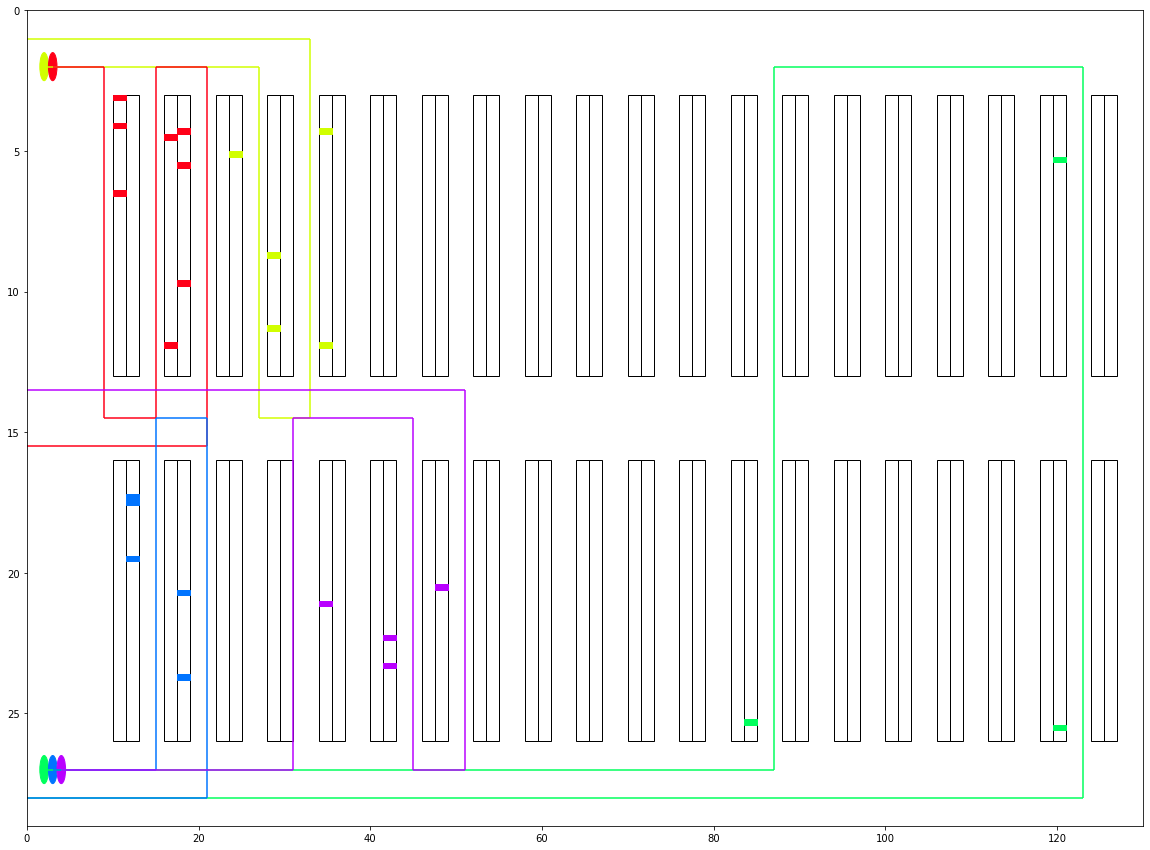

In [26]:
print_graph(varInfo5)

In [13]:
def print_comp(varInfo,typ):
    import re
    # extract the values of the x variable from varInfo
    x_values = [var[0] for var in varInfo if var[0].startswith('x_')]
    newnames=[]
    for i in x_values:
        split_string = re.findall(r'\d+', i)
        newnames.append(split_string)
    assign=[]
    for j in range(0,len(newnames)):
        assign.append(newnames[j][1])
    orderinfo['batch']=assign
    # Define the layout of the warehouse
    # Here we will assume a simple 2D layout with fixed dimensions
    warehouse_width = 130/10
    warehouse_height = 29/10
    import seaborn as sns
    a=sns.color_palette('hls',B)
    a=a.as_hex()
    # Create a figure and axis for the warehouse layout
    #fig, ax = plt.subplots(figsize=(warehouse_width, warehouse_height))
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.set_xlim(0, warehouse_width)
    ax.set_ylim(0, warehouse_height)
    x_val=orderinfo['a_k'].tolist()
    y_val=orderinfo['r_k'].tolist()
    #add robots
    avg_x=orderinfo.groupby('batch')['a_k'].mean().reset_index()
    avg_y=orderinfo.groupby('batch')['r_k'].mean().reset_index()
    avg_y['color'] = avg_y['batch'].replace(avg_y['batch'].tolist(),a)
    
    orderinfo['cen_x'] = orderinfo['batch'].replace(avg_x['batch'].tolist(),avg_x['a_k'].tolist())
    orderinfo['cen_y'] = orderinfo['batch'].replace(avg_y['batch'].tolist(),avg_y['r_k'].tolist())
    orderinfo['color'] = orderinfo['batch'].replace(avg_y['batch'].tolist(),a)
    ax.add_patch(plt.Rectangle((2/10, 2/10), 0.08, 2.5,  fill=None, alpha=1))
    for i in range(0,len(orderinfo)):
        clr=int(orderinfo['batch'][i])
        ax.add_patch(plt.Rectangle((x_val[i]/10, y_val[i]/10), 0.08, 0.08, color=orderinfo['color'][i]))
        x=[x_val[i]/10, orderinfo['cen_x'][i]/10]
        y=[y_val[i]/10, orderinfo['cen_y'][i]/10]
        plt.plot(x, y, c=orderinfo['color'][i], alpha=0.5)
    for b in range(0,len(avg_x)):
        center_x=avg_x['a_k'][b]
        center_y=avg_y['r_k'][b]
        ax.add_patch(plt.Circle((center_x/10, center_y/10), 0.05, color=avg_y['color'][b]))
    fig.set_size_inches(20, 15)
    ax.invert_yaxis()
    tit='OBP'+str(typ)+' results with distances to center of batches \n'
    plt.title(tit, loc='center', fontsize=22)
    name_file='dist_'+str(typ)+'.png'
    fig.savefig(name_file, dpi=100)
    plt.show()


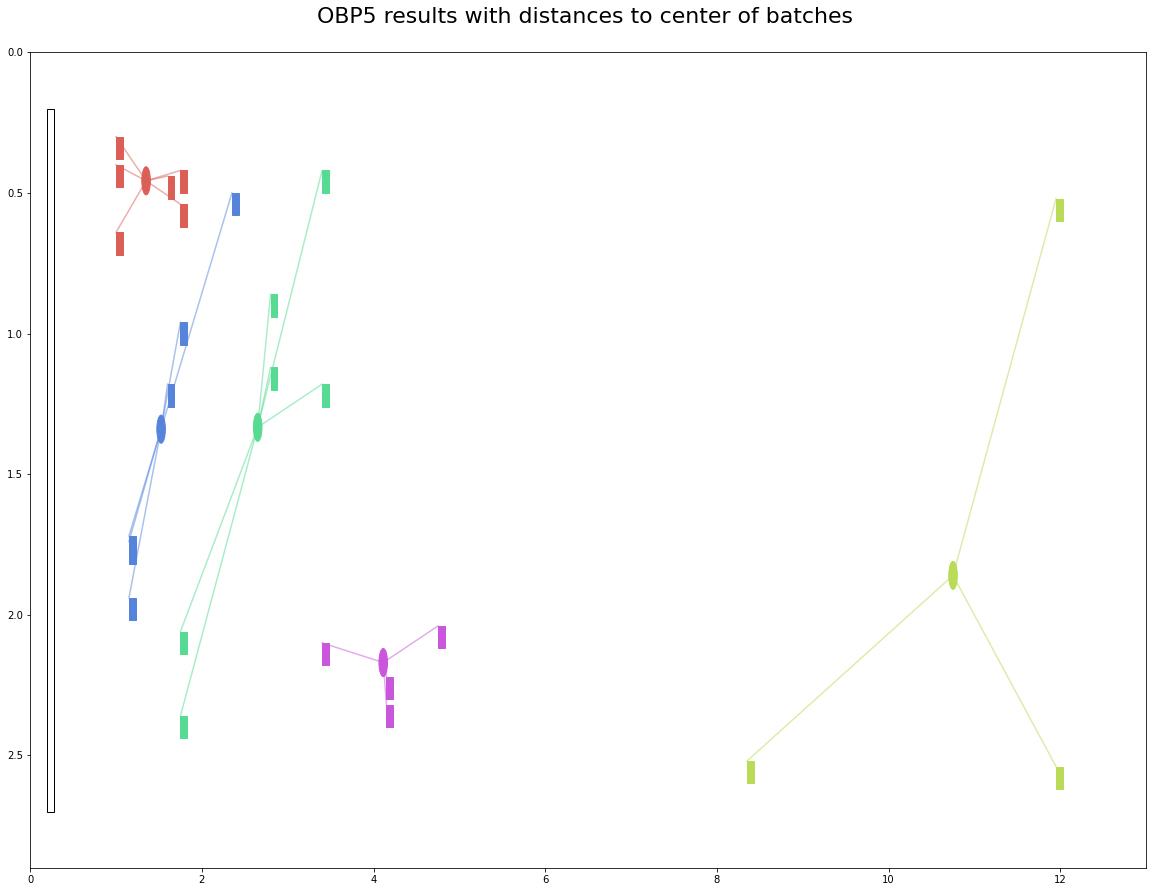

In [14]:
print_comp(varInfo5,5)

In [27]:
#SA algorithm without gurobi
import random
from math import exp
from tqdm import tqdm
from sklearn.cluster import KMeans
# Simulated Annealing parameters
initial_temperature = 100
final_temperature = 0.0001
cooling_factor = 1-0.01
num_iterations = 1000
# Generate initial solution
def generate_initial_solution():
    X = orderinfo[['a_k', 'r_k']]
    kmeans = KMeans(n_clusters=B).fit(X)
    labels = kmeans.labels_
    X['cluster']=labels
    solution = [[0] * B for _ in range(I)]
    batch_capacity = [T] * B  # Remaining capacity of each batch

    # Sort orders based on their priority (a_k / r_k) in descending order
    order_priorities = [orderinfo['a_k'].values[i] / orderinfo['r_k'].values[i] for i in range(I)]
    sorted_orders = sorted(range(I), key=lambda x: order_priorities[x], reverse=True)

    for order in sorted_orders:
        chosen_batch = labels[order]

        # Check if assigning the order to the selected batch exceeds the capacity constraint
        if batch_capacity[chosen_batch] >= m_i[order]:
            solution[order][chosen_batch] = 1
            batch_capacity[chosen_batch] -= m_i[order]
        else:
            # Find an alternative batch with sufficient capacity
            for b in range(B):
                if batch_capacity[b] >= m_i[order]:
                    solution[order][b] = 1
                    batch_capacity[b] -= m_i[order]
                    break
    return solution
# Evaluate fitness of a solution
def evaluate_fitness(solution):
    # Check the constraints and calculate the objective function value
    obj = 0
    for i in range(I):
        for j in range(I):
            obj += d_ij[i][j] * sum(solution[i][b] * solution[j][b] for b in range(B))
    # Check the capacity constraints
    for b in range(B):
        cap_constraint=sum(m_i[i]*solution[i][b] for i in range(I))
        if cap_constraint > T:
            obj=100000
    return obj

# Generate a neighboring solution by randomly flipping one bit
def generate_neighbor(solution):
    neighbor = [row[:] for row in solution]  # Create a copy of the solution

    # Find the indices of 1 values and 0 values
    ones_indices = [(i, b) for i in range(I) for b in range(B) if solution[i][b] == 1]
    zeros_indices = [(i, b) for i in range(I) for b in range(B) if solution[i][b] == 0]

    if len(ones_indices) > 0 and len(zeros_indices) > 0:
        # Randomly select a 1 value
        one_index = random.choice(ones_indices)

        # Randomly select a 0 value that belongs to the same item
        item_index = one_index[0]
        eligible_zeros_indices = [(i, b) for i, b in zeros_indices if i == item_index]
        zero_index = random.choice(eligible_zeros_indices)

        # Swap the values
        neighbor[one_index[0]][one_index[1]] = 0
        neighbor[zero_index[0]][zero_index[1]] = 1

    return neighbor
# Perform simulated annealing
def simulated_annealing(initial_temperature,cooling_factor,current_solution):
    start_time = time.perf_counter()
    #current_solution= generate_initial_solution()
    current_fitness = evaluate_fitness(current_solution)
    #print(current_fitness)
    best_solution = current_solution
    best_fitness = current_fitness

    temperature = initial_temperature

    for _ in range(num_iterations):
        # Generate a neighboring solution
        neighbor = generate_neighbor(current_solution)
        neighbor_fitness = evaluate_fitness(neighbor)
        #cool down
        temperature *= cooling_factor
        if neighbor_fitness <= current_fitness:
            current_solution = neighbor
            current_fitness = neighbor_fitness
            if neighbor_fitness <=best_fitness:
                best_solution = neighbor
                best_fitness = neighbor_fitness
        elif math.exp((current_fitness - neighbor_fitness) / temperature) >=random.random():
            current_solution = neighbor
            current_fitness = neighbor_fitness
        #print(current_fitness)
        #print_comp_2(current_solution)
        if temperature < final_temperature:
            break
    end_time = time.perf_counter()
    return best_solution, best_fitness,end_time-start_time


In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
n, B, n_r, T,K,alpha, orderinfo,I,m_i,a_ik,d_ij=parameters(n_list[0])
fitness=[]
best_sols=[]
it=[]
best_times=[]
iteration=5
initial_temperature=100
for _ in tqdm(range(iteration)):
    if _ ==0:
        best_curent=[]
        best_fit=[]
        for i in range(0,100):
            curent=generate_initial_solution()
            vals=evaluate_fitness(curent)
            best_curent.append(curent)
            best_fit.append(vals)
        min_ind=best_fit.index(min(best_fit))
        curent=best_curent[min_ind]
        print(best_fit[min_ind])
    else:
        curent=best_solution
    best_solution, best_fitness,timeval = simulated_annealing(initial_temperature,cooling_factor,curent)
    fitness.append(best_fitness)
    it.append(_)
    best_sols.append(best_solution)
    best_times.append(timeval)
fitness.index(min(fitness))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

2132.3999999999983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


1

In [30]:
def print_comp_2(best_solution):
    import re
    batch_list=[]
    for i in range(I):
        index = best_solution[i].index(1)
        batch_list.append(index+1)
    orderinfo['batch']=batch_list
    # Define the layout of the warehouse
    # Here we will assume a simple 2D layout with fixed dimensions
    warehouse_width = 130/10
    warehouse_height = 29/10
    import seaborn as sns
    a=sns.color_palette('hls',B)
    a=a.as_hex()
    # Create a figure and axis for the warehouse layout
    #fig, ax = plt.subplots(figsize=(warehouse_width, warehouse_height))
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.set_xlim(0, warehouse_width)
    ax.set_ylim(0, warehouse_height)
    x_val=orderinfo['a_k'].tolist()
    y_val=orderinfo['r_k'].tolist()
    #add robots
    avg_x=orderinfo.groupby('batch')['a_k'].mean().reset_index()
    avg_y=orderinfo.groupby('batch')['r_k'].mean().reset_index()
    avg_y['color'] = avg_y['batch'].replace(avg_y['batch'].tolist(),a)
    
    orderinfo['cen_x'] = orderinfo['batch'].replace(avg_x['batch'].tolist(),avg_x['a_k'].tolist())
    orderinfo['cen_y'] = orderinfo['batch'].replace(avg_y['batch'].tolist(),avg_y['r_k'].tolist())
    orderinfo['color'] = orderinfo['batch'].replace(avg_y['batch'].tolist(),a)
    ax.add_patch(plt.Rectangle((2/10, 2/10), 0.08, 2.5,  fill=None, alpha=1))
    for i in range(0,len(orderinfo)):
        clr=int(orderinfo['batch'][i])
        ax.add_patch(plt.Rectangle((x_val[i]/10, y_val[i]/10), 0.08, 0.08, color=orderinfo['color'][i]))
        x=[x_val[i]/10, orderinfo['cen_x'][i]/10]
        y=[y_val[i]/10, orderinfo['cen_y'][i]/10]
        plt.plot(x, y, c=orderinfo['color'][i], alpha=0.5)
    for b in range(0,len(avg_x)):
        center_x=avg_x['a_k'][b]
        center_y=avg_y['r_k'][b]
        ax.add_patch(plt.Circle((center_x/10, center_y/10), 0.05, color=avg_y['color'][b]))
    fig.set_size_inches(20, 15)
    ax.invert_yaxis()
    #tit='SA results with distances to center of batches \n'
    #plt.title(tit, loc='center', fontsize=22)
    name_file='dist_SA.png'
    fig.savefig(name_file, dpi=400)
    plt.show()

In [32]:
def print_graphSA(best_solution):
    import re
    batch_list=[]
    for i in range(I):
        index = best_solution[i].index(1)
        batch_list.append(index+1)
    orderinfo['batch']=batch_list
    # Define the layout of the warehouse
    # Here we will assume a simple 2D layout with fixed dimensions
    warehouse_width = 130
    warehouse_height = 29
    cmap = get_cmap(B+1)
    # Create a figure and axis for the warehouse layout
    fig, ax = plt.subplots(figsize=(warehouse_width, warehouse_height))
    ax.set_xlim(0, warehouse_width)
    ax.set_ylim(0, warehouse_height)
    x_val=orderinfo['a_k'].tolist()
    y_val=orderinfo['r_k'].tolist()
    #add robots
    avg=orderinfo.groupby('batch')['r_k'].mean().reset_index()
    top=avg.loc[avg['r_k']<=16]
    bottom=avg.loc[avg['r_k']>16]
    toplist=top['batch'].tolist()
    bottomlist=bottom['batch'].tolist()
    topisle=[i for i in range(1,22)]
    bottomisle=[l for l in range(22,43)]
    allisle=[i for i in range(1,43)]
    points=[]
    points.append(10)
    for i in range(14,129,6):
        points.append(i)
    edges=dict(zip(allisle, points*2))
    for i in range(0,len(toplist)):
        ax.add_patch(plt.Circle((i+2, 2), 0.5, color=cmap(int(toplist[i])))) 
        res_1 = dict(zip(topisle, bottomisle))
        res_2 = dict(zip(bottomisle, topisle))
        try_1=orderinfo.loc[orderinfo['batch']==toplist[i]]
        try_isle=try_1['isle'].unique().tolist()
        small_list = [int(t) for t in try_isle if int(t) <22]
        large_list = [res_2[int(t)] for t in try_isle if int(t) >= 22]
        small=['s']*len(small_list)
        large=['l']*len(large_list)
        all_list=small_list+large_list
        all_name=small+large
        dict_all = dict(zip(all_list, all_name))
        myKeys = list(dict_all.keys())
        myKeys.sort()
        sorted_dict = {i: dict_all[i] for i in myKeys}
        #small_list.sort()
        #large_list.sort()
        initial_point=[i+2,2]
        
        for k in range(0,len(sorted_dict)):
            ind=list(sorted_dict.keys())[k]
            if k!=len(sorted_dict)-1:
                lar=list(sorted_dict.values())[k+1]
            else:
                lar=list(sorted_dict.values())[k]
            if k%2==0:
                if k==0 and ind%2!=0:
                    indxl=edges[ind]-1
                else:
                    indxl=edges[ind]+1
                new_point=[indxl,2]
                ax.hlines(y = initial_point[1], xmin = initial_point[0], xmax = new_point[0],color = cmap(int(toplist[i])))
                if list(sorted_dict.values())[k]=='l' or lar=='l':
                    ax.vlines(x = new_point[0], ymin = initial_point[1], ymax = 27, colors = cmap(int(toplist[i])))
                    initial_point=[indxl, 27]
                else:
                    ax.vlines(x = new_point[0], ymin = initial_point[1], ymax = 14.5, colors = cmap(int(toplist[i])))
                    initial_point=[indxl, 14.5]
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point[0], ymin =initial_point[1] , ymax =initial_point[1]+1 , colors = cmap(int(toplist[i])))
                    ax.hlines(y = initial_point[1]+1, xmin = 0, xmax = new_point[0],color = cmap(int(toplist[i])))

            else:
                if initial_point[1]==27:
                    new_point=[edges[ind]+1, 27]
                else:
                    new_point=[edges[ind]+1, 14.5]
                ax.hlines(y = initial_point[1], xmin = initial_point[0], xmax = new_point[0],color = cmap(int(toplist[i])))
                initial_point=[edges[ind]+1,2]
                ax.vlines(x = new_point[0], ymin =initial_point[1] , ymax =new_point[1] , colors = cmap(int(toplist[i])))
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point[0], ymin =initial_point[1] , ymax =initial_point[1]-1 , colors = cmap(int(toplist[i])))
                    ax.hlines(y = initial_point[1]-1, xmin = 0, xmax = new_point[0],color = cmap(int(toplist[i])))
                
    for i in range(0,len(bottomlist)):
        ax.add_patch(plt.Circle((i+2, 27), 0.5, color=cmap(int(bottomlist[i]))))
        res_1 = dict(zip(topisle, bottomisle))
        res_2 = dict(zip(bottomisle, topisle))
        try_2=orderinfo.loc[orderinfo['batch']==bottomlist[i]]
        try_isle2=try_2['isle'].unique().tolist()
        small_list2 = [res_1[int(t)] for t in try_isle2 if int(t) <22]
        large_list2 = [int(t) for t in try_isle2 if int(t) >= 22]
        small=['s']*len(small_list2)
        large=['l']*len(large_list2)
        all_list=large_list2+small_list2
        all_name=large+small
        dict_all = dict(zip(all_list, all_name))
        myKeys = list(dict_all.keys())
        myKeys.sort()
        sorted_dict = {i: dict_all[i] for i in myKeys}
        #small_list2.sort()
        #large_list2.sort()
        initial_point2=[i+2,27]
        
        for k in range(0,len(sorted_dict)):
            ind=list(sorted_dict.keys())[k]
            if k!=len(sorted_dict)-1:
                sma=list(sorted_dict.values())[k+1]
            else:
                sma=list(sorted_dict.values())[k]
            if k%2==0:
                if k==0 and ind%2==0:
                    indxl=edges[ind]-1
                else:
                    indxl=edges[ind]+1
                new_point2=[indxl,27]
                ax.hlines(y = initial_point2[1], xmin = initial_point2[0], xmax = new_point2[0],color = cmap(int(bottomlist[i])))
                if list(sorted_dict.values())[k]=='s' or sma=='s':
                    ax.vlines(x = new_point2[0], ymin = 2, ymax = 27, colors = cmap(int(bottomlist[i])))
                    initial_point2=[indxl, 2]
                else:
                    if ind==26:
                        print(new_point2[0])
                    ax.vlines(x = new_point2[0], ymin =14.5 , ymax = initial_point2[1], colors = cmap(int(bottomlist[i])))
                    initial_point2=[indxl, 14.5]
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point2[0], ymin =initial_point2[1] , ymax =initial_point2[1]-1 , colors = cmap(int(bottomlist[i])))
                    ax.hlines(y = initial_point2[1]-1, xmin = 0, xmax = new_point2[0],color = cmap(int(bottomlist[i])))

            else:
                if initial_point2[1]==2:
                    new_point2=[edges[ind]+1, 2]
                else:
                    new_point2=[edges[ind]+1, 14.5]
                ax.hlines(y = initial_point2[1], xmin = new_point2[0], xmax = initial_point2[0],color = cmap(int(bottomlist[i])))
                initial_point2=[edges[ind]+1,27]
                ax.vlines(x = new_point2[0], ymin =new_point2[1] , ymax =initial_point2[1] , colors = cmap(int(bottomlist[i])))
                if k==len(sorted_dict)-1:
                    ax.vlines(x = new_point2[0], ymin =initial_point2[1] , ymax =initial_point2[1]+1 , colors = cmap(int(bottomlist[i])))
                    ax.hlines(y = initial_point2[1]+1, xmin = 0, xmax = new_point2[0],color = cmap(int(bottomlist[i])))
                
        
    #Create the layout of the racks

    for i in range(10,128,6):
        #top racks
        ax.add_patch(plt.Rectangle((i, 3), 1.5, 10, fill=None, alpha=1))
        ax.add_patch(plt.Rectangle((i+1.5, 3), 1.5, 10, fill=None, alpha=1))
        #bottom racks
        ax.add_patch(plt.Rectangle((i, 16), 1.5, 10, fill=None, alpha=1))
        ax.add_patch(plt.Rectangle((i+1.5, 16), 1.5, 10, fill=None, alpha=1))
    # Place the items in the warehouse based on the results

    for i in range(0,len(orderinfo)):
        clr=int(orderinfo['batch'][i])
        ax.add_patch(plt.Rectangle((x_val[i], y_val[i]), 1.5, 0.2, color=cmap(clr)))
    
    fig.set_size_inches(20, 15)
    ax.invert_yaxis()
    #tit=str(n)+str(' orders with ')+str(I)+str(' items and ')+str(B)+str(' batches')
    #plt.title(tit)
    fig.savefig('route.png', dpi=400)
    plt.show()

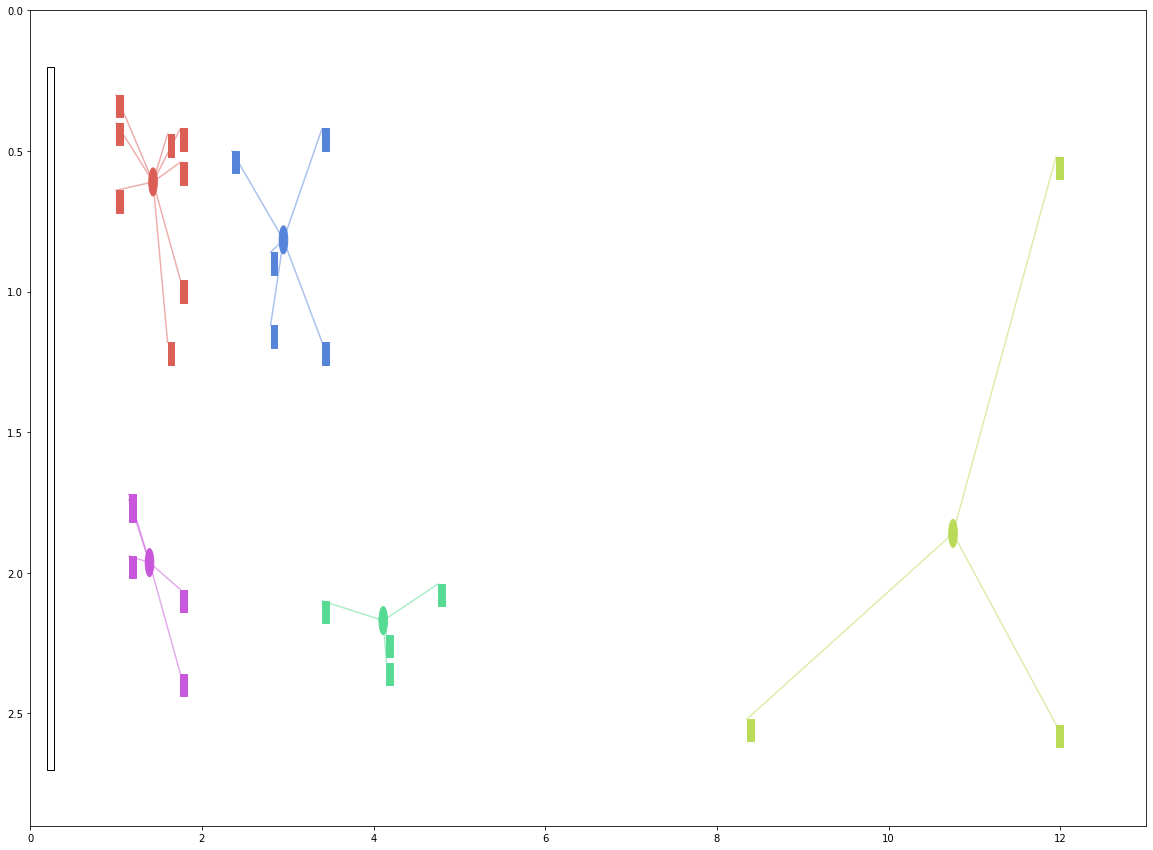

In [31]:
ind=fitness.index(min(fitness))
best_solution=best_sols[ind]
best_fitness=fitness[ind]
timebest=best_times[ind]
print_comp_2(best_sols[ind])

31


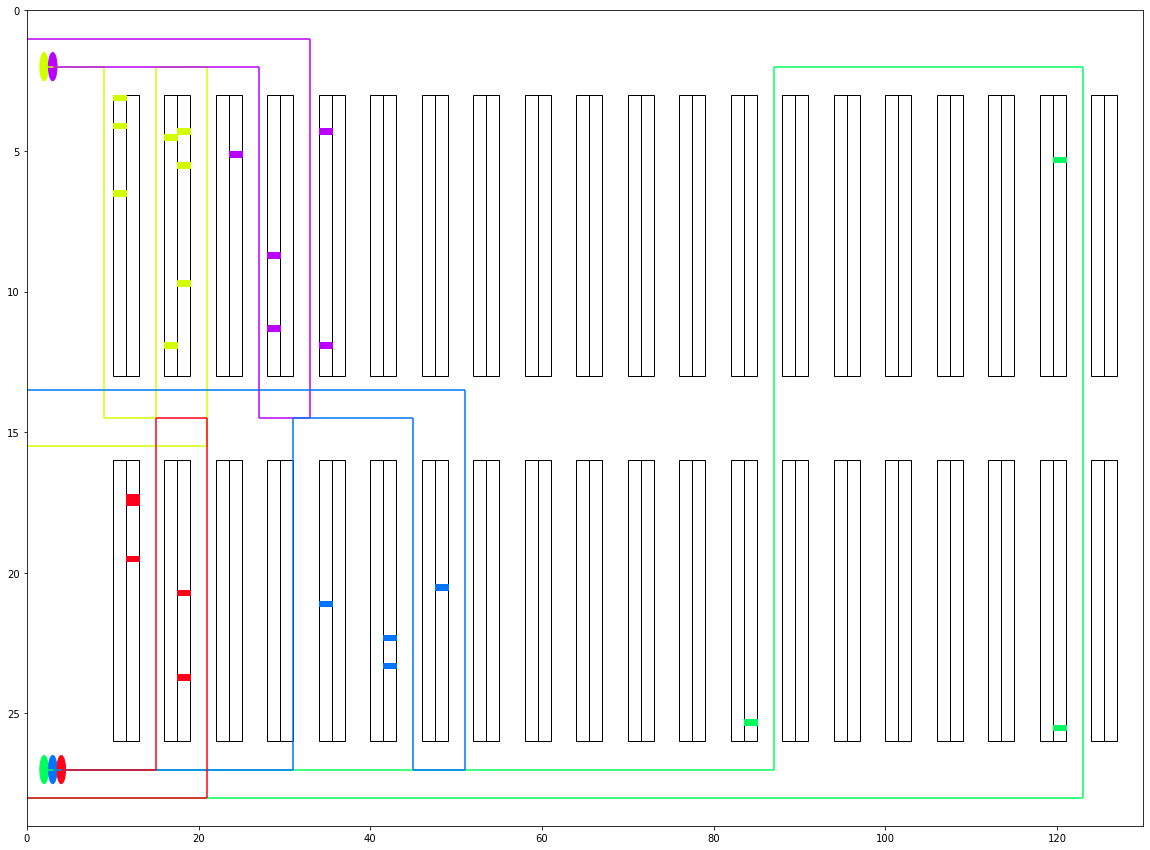

In [33]:
print_graphSA(best_sols[ind])